In [1]:
import os
import numpy as np
import glob
from tess_sip import SIP
from astropy.coordinates import SkyCoord
from astropy import units as u
import lightkurve as lk
from astroquery.mast import Tesscut
import tess_cpm
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

sys.path.insert(0, "../")
sys.path.insert(0, "../../Packages/eleanor/")
import eleanor

import warnings
warnings.filterwarnings('ignore')

from michael import janet

In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

index = uni[uni.source_id == int(2174289161681454720)].index[0]

In [3]:
j = janet.boot(uni, index=index)


In [4]:
coords = SkyCoord(ra = j.ra, dec = j.dec, unit = (u.deg, u.deg))


In [5]:
from michael.data import data_class
d = data_class(j)
d.setup_data()

Target DR3 ID 2174289161681454720 has tesscut data available on MAST for Sectors 16, 17, 56, 57
Data already downloaded for Sector 16.
Data already downloaded for Sector 17.
Data already downloaded for Sector 56.
Data already downloaded for Sector 57.


In [6]:
d.build_eleanor_lc()

In [8]:
d.build_tess_sip_lc(detrended=True)

Running pixels in aperture: 100%|█████████████| 300/300 [00:03<00:00, 81.88it/s]


In [9]:
d.build_unpopular_lc()


Removing 11 bad data points (out of 10802) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 3 bad data points (out of 1121) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 4 bad data points (out of 1130) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median
Removing 9 bad data points (out of 11775) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median


In [10]:
sfiles = []
for sector in j.sectors:
    split = sector.split('-')
    if len(split) > 1:
        sfiles = []
        for s in np.arange(int(split[0]), int(split[1])+1):
            strlen = np.floor(np.log10(s)).astype(int)+1
            secstr = 's0000'[:-strlen] + str(s)

            sfile = glob.glob(f'{d.path}'+
                                f'*{secstr}*astrocut.fits')

            if len(sfile) == 0:
                raise ValueError("No tesscut files could be found for this target.")

            sfiles.append(sfile[0])

        tpflist = [lk.TessTargetPixelFile(f).cutout([26,26],13) for f in sfiles]
        tpfs = lk.TargetPixelFileCollection(tpflist)

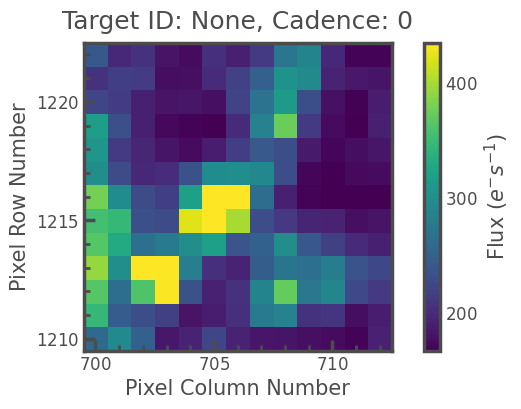

In [11]:
img = tpfs[1].plot();
plt.show()

In [19]:
lims = img.get_images()[0].get_clim()

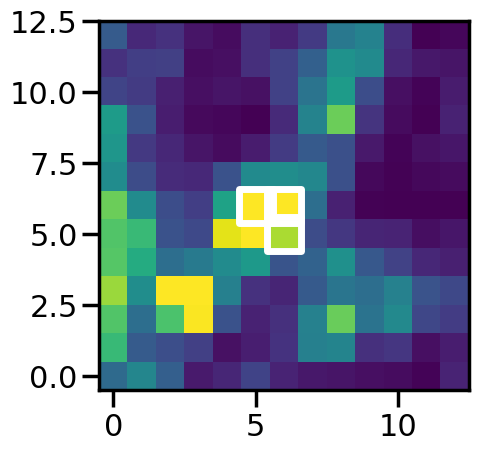

In [20]:
plt.imshow(j.void['datum_57'].tpf[0], origin='lower',
          vmin = lims[0], vmax = lims[1])
pix = np.where(j.void[f'datum_57'].aperture > 0)
plt.scatter(pix[0], pix[1], edgecolors='w', lw=5, marker=',', facecolors='none', s=600, zorder=2, label='Aperture')
plt.show()

In [27]:
sfile = sfiles[1]
cpm = tess_cpm.Source(sfile, remove_bad=True)
aperture = j.void[f'datum_{s}'].aperture
rowlims = 19 + np.array([np.where(aperture>.75)[0].min(), np.where(aperture>.75)[0].max()])
collims = 19 + np.array([np.where(aperture>.75)[1].min(), np.where(aperture>.75)[1].max()])
cpm.set_aperture(rowlims = rowlims, collims = collims)

# We use 200 predictors for a stamp of this size. This is a rough
# guesstimate from trial-and-error, but seems to work well.
cpm.add_cpm_model(exclusion_size=6, n=200,
    predictor_method = "similar_brightness")
cpm.set_regs([0.1])
cpm.holdout_fit_predict(k=100, verbose=False)

# Save corrected flux as a lightcurve object for this sector
flux = cpm.get_aperture_lc(data_type="cpm_subtracted_flux",
                            weighting='median')

Removing 11 bad data points (out of 10802) using the TESS provided QUALITY array
Summing over 2 x 2 pixel lightcurves. Weighting=median


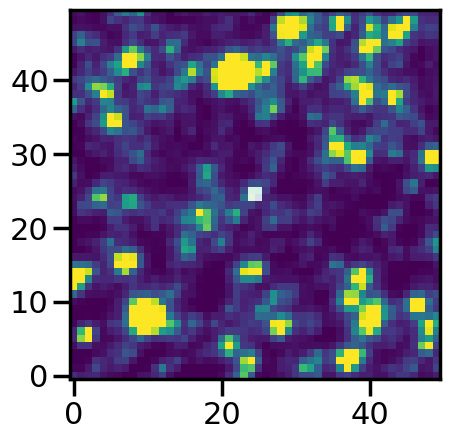

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

In [31]:
cpm.plot_cutout(show_aperture=True, l=5, h=95)

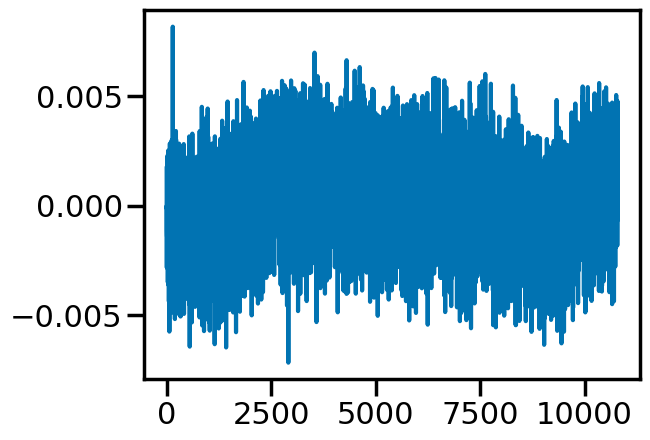

In [34]:
plt.plot(flux)
plt.show()

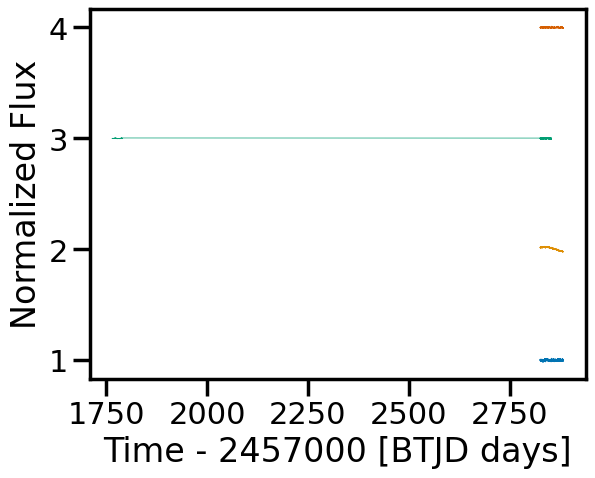

In [42]:
fig, ax = plt.subplots()
for i, m in enumerate(['c','r','cpm','rdt']):
    (j.void[f'{m}lc_56-57'] + i).plot(ax=ax)
plt.show()